In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets
import matplotlib.pyplot as plt
%matplotlib inline

### hyperparameter tunning

In [2]:
num_epochs = 50
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32,32,3)
num_classes = 10

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32,(3,3), padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs= inputs, outputs=net, name = 'Basic_CNN')

In [4]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

### data preprocess

In [5]:
train_paths = glob('cifar/train/*.png')[:1000]
test_paths = glob('cifar/test/*.png')[:1000]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png','')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png','')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot) # label번호를 반환

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls = AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls = AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size = len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls = AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

### history 들여다보기

In [14]:
steps_per_epoch = len(train_paths) //batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch = steps_per_epoch,
    validation_data = test_dataset,
    validation_steps = validation_steps,
    epochs = num_epochs,)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
31/31 [==============================] - 4s 124ms/step - loss: 2.2981 - accuracy: 0.1074 - val_loss: 2.2477 - val_accuracy: 0.1149
Epoch 2/50
31/31 [==============================] - 4s 120ms/step - loss: 2.2410 - accuracy: 0.1601 - val_loss: 2.2296 - val_accuracy: 0.2379
Epoch 3/50
31/31 [==============================] - 4s 120ms/step - loss: 2.1788 - accuracy: 0.2025 - val_loss: 2.1251 - val_accuracy: 0.2208
Epoch 4/50
31/31 [==============================] - 4s 119ms/step - loss: 2.1531 - accuracy: 0.1994 - val_loss: 2.0899 - val_accuracy: 0.2359
Epoch 5/50
31/31 [==============================] - 4s 116ms/step - loss: 2.0611 - accuracy: 0.2417 - val_loss: 2.0227 - val_accuracy: 0.2621
Epoch 6/50
31/31 [==============================] - 4s 120ms/step - loss: 2.0211 - accuracy: 0.2440 - val_loss: 2.0714 - val_accuracy: 0.2581
Epoch 7/50
31/31 [==============================] - 4s 122ms/step - loss

In [16]:
path = test_paths[0]
path

'cifar/test\\0_cat.png'

In [19]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image.shape

TensorShape([32, 32, 3])

In [20]:
image = image[tf.newaxis,...]

In [21]:
image.shape

TensorShape([1, 32, 32, 3])

In [22]:
pred = model.predict(image)

In [23]:
pred.shape

(1, 10)

In [24]:
np.argmax(pred)

7

### generator에서 데이터를 가져오는 방법

In [25]:
test_image, test_label = next(iter(test_dataset))

In [26]:
test_image.shape

TensorShape([32, 32, 32, 3])

In [27]:
pred = model.predict(test_image)

In [28]:
pred.shape

(32, 10)

In [29]:
pred[0]

array([0.0044678 , 0.00158701, 0.01123246, 0.1049071 , 0.16934122,
       0.1176418 , 0.0218003 , 0.51319873, 0.00291123, 0.05291233],
      dtype=float32)

In [30]:
np.argmax(pred[0])

7

### generator에 넣는 방법

(32, 32, 32, 3)


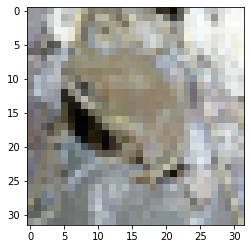

In [38]:
for image, label in test_dataset.take(1): # 배치 갯수 정하기
    print(image.shape)
    plt.imshow(image[31])
    plt.show()

In [40]:
pred = model.predict(test_dataset.take(1))

In [41]:
pred.shape

(32, 10)

In [43]:
np.argmax(pred[0])

7

In [44]:
image, label = test_dataset.take(1)

ValueError: not enough values to unpack (expected 2, got 1)

In [45]:
model.evaluate(image,label)

1/1 [==============================] - 0s 997us/step - loss: 1.6492 - accuracy: 0.5000


[1.6491848230361938, 0.5]